## Task 1

Modify your uniform density sphere code to simulate the time-dependent leakage of packets from the outer edge of a sphere of radius 1 metre. Assume the sphere is illuminated by a central isotropic point source of radiation. You should produce a figure that plots number of packets against the time it takes them to travel from the source to the edge of the sphere (i.e., bin the packets according to their total time of flight in the sphere and assume they travel at the speed of light). Assume the scattering albedo is unity, and present results on a single figure for simulations with radial optical depths 0.1, 1, 10, 30, 100.

In [3]:
program uni_sphere_time_dep
    implicit none
    double precision :: r_prev,x,y,z,nx,ny,nz,tau,r,rmax,E,L,travel_dist,bw,ToF,max_ToF,gamma,dist_correction
    double precision, parameter :: c = 3.d8  
    integer :: npackets,i,j,k,n,nbins,ntaus
    !double precision, allocatable, dimension(:) :: ToF_i
    integer, allocatable, dimension(:) :: binned_ToFs 
    !double precision, allocatable, dimension(:,:) :: ToFs
    double precision, allocatable, dimension(:) :: tau_rs
    integer :: clock_start, clock_end, clock_rate, elapsed_time

    npackets = 10**6
    nbins = 100
    ntaus = 5
    rmax = 1.d0
    max_ToF = 3.d-7 ! Set an upper limit for binning
    bw = max_ToF/REAL(nbins) ! Bin width
    
    ! Initialize the clock
    call SYSTEM_CLOCK(count_rate=clock_rate)
    call SYSTEM_CLOCK(count=clock_start)
    
    allocate(tau_rs(ntaus))
    allocate(binned_ToFs(nbins))
    
    tau_rs = (/1.d-1, 1.d0, 1.d1, 3.d1, 1.d2/) ! Length 5
    open(unit=1, file = 'HW1_1.txt')
 
    do i = 1,ntaus ! Loop through the optical depths
        binned_ToFs = 0 ! Need to start with empty bins for each optical depth
        do j = 1, npackets ! Loop through the packets
            travel_dist = 0 ! We want the distance travelled by each packet so we need to restart this for every j 
            ! iteration
            call emit_packet(x,y,z,nx,ny,nz) ! Create a packet at the origin with random nx, ny, nz direction
            r = SQRT(x*x + y*y + z*z) ! Need this to start the WHILE loop
            do while (r <= rmax) ! Packet is in sphere
                call random_number(E)
                tau = -log(E) ! The optical depth travelled in this leg of the journey
                L = tau * rmax / tau_rs(i) ! Distance travelled
                travel_dist = travel_dist + L ! Add this distance travelled to the rest of the journey
                ! Update packet position, x,y,z
                x = x + L * nx
                y = y + L * ny
                z = z + L * nz
                r = SQRT(x*x + y*y + z*z) ! New radius
                if (r >= rmax) EXIT ! Package escapes the spherical medium. We need to notice that the final L added 
                ! often gives an r > rmax so our total distance travelled accounts for flight beyond the sphere edge. 
                ! We need to correct this
                call ran_dir(nx,ny,nz) ! If the package does not exit the medium then it is scattered isotropically and 
                ! the cycle begins anew with a new leg of the journey
            end do
            r_prev = SQRT((x - L * nx)*(x - L * nx) + (y - L * ny)*(y - L * ny) + (z - L * nz)*(z - L * nz)) ! This is 
            ! the radius at the last scattering site before escape
            ! Look at attached sketch with the derivation of the needed distance correction
            gamma = ABS(dot_product([x-L*nx,y-L*ny,z-L*nz],[nx,ny,nz]))
            dist_correction = gamma + SQRT(gamma*gamma + rmax*rmax - r_prev*r_prev) ! This is Lrem
            travel_dist = travel_dist - L + dist_correction ! This gives the correct total distance travelled until
            ! contact with the radius of the sphere
            ToF = travel_dist/c ! Time-of-Flight in seconds
            n = FLOOR(ToF/bw) + 1
            if (n < nbins) then ! ToF/bw can give values bigger than the number of bins as we have set an arbitrary
            ! upper limit to the bin range. This would give values of n outside the range of binned_ToFs and produce
            ! errors. Hence, we require this condition
                binned_ToFs(n) = binned_ToFs(n) + 1 ! We increase the count in the bin with the corresponding ToF
                !end if
            end if
        end do
        do k = 1, nbins
            write(1,*) bw*k, binned_ToFs(k)
        end do
        print*, 'Done!'
    end do
    
    ! Get the ending time
    call SYSTEM_CLOCK(count=clock_end)

    ! Calculate the elapsed time in seconds
    elapsed_time = (clock_end - clock_start) / clock_rate

    print *, 'Elapsed time (seconds):', elapsed_time
    
    close(unit=1)
end program uni_sphere_time_dep

subroutine emit_packet(x,y,z,nx,ny,nz)
    implicit none
    double precision, parameter :: pi = 3.14159
    double precision :: E1,E2,theta,phi
    double precision, intent(out) :: x,y,z,nx,ny,nz
    x=0
    y=0
    z=0
    call ran_dir(nx,ny,nz)
end subroutine emit_packet

subroutine ran_dir(nxs,nys,nzs)
    implicit none
    double precision, parameter :: pi = 3.14159
    double precision :: E1,E2,theta,phi
    double precision, intent(out) :: nxs,nys,nzs
    call random_number(E1)
    call random_number(E2)
    theta = ACOS(2*E1 - 1)
    phi = 2*pi*E2
    nxs = SIN(theta)*COS(phi)
    nys = SIN(theta)*SIN(phi)
    nzs = COS(theta)
end subroutine ran_dir

 Done!
 Done!
 Done!
 Done!
 Done!
 Elapsed time (seconds):         995


The programme above simulates the emission of $10^6$ packets being emitted from a central isotropic point source of radiation and travelling a uniform (the interaction cross-section $\sigma$ and the particle number density $n$ the same everywhere within the sphere) spherical medium with radius $r_{max} = 1$. All distances are in meters. Functions emit_packet and ran_dir ensure that the generated initial location is always at the origin $(x=0,y=0,z=0)$ and the initial direction is randomly generated using the equations derived in lectures. We denote the edge of the medium by introducing the condition that when the radial position of a packet $r \geq r_{max}$ we exit the WHILE loop meaning that we do not continue to track the packet as it has left the simulation (medium).

The scattering albedo $a$ is unity meaning that every interaction within the medium results in (isotropic) scattering. Hence, we can omit producing a random number to determine whether a given packet is absorbed of scattered. For this reason, there is no action in this code involving an albedo value.

5 simulations are exectued for each $\tau_r = (0.1, 1, 10, 30, 100)$. During each of them, $10^6$ packets are emitted with a counter travel_dist starting at $0$ for each one. The packets are passed to a WHILE loop that continues as long as the packet currently in the loop is within the sphere. In the loop, a random $\tau$ is produced and used to calculate the distance travelled $L$ by a packet during this leg of the journey (loop iteration). $L$ is stored in travel_dist and if the packet is still within the medium it is scattered isotropically by ran_dir and a new iteration begins. When the packet finally leaves the medium and the while loop is exited, travel_dist cannot be directly used to calculated time-of-flight (ToF) because it likely accounts for some distance travelled outside the medium. This is corrected as given by the expression below for which we calculated $r_{prev}$ the location of the packet before it was last propagated to its final location.

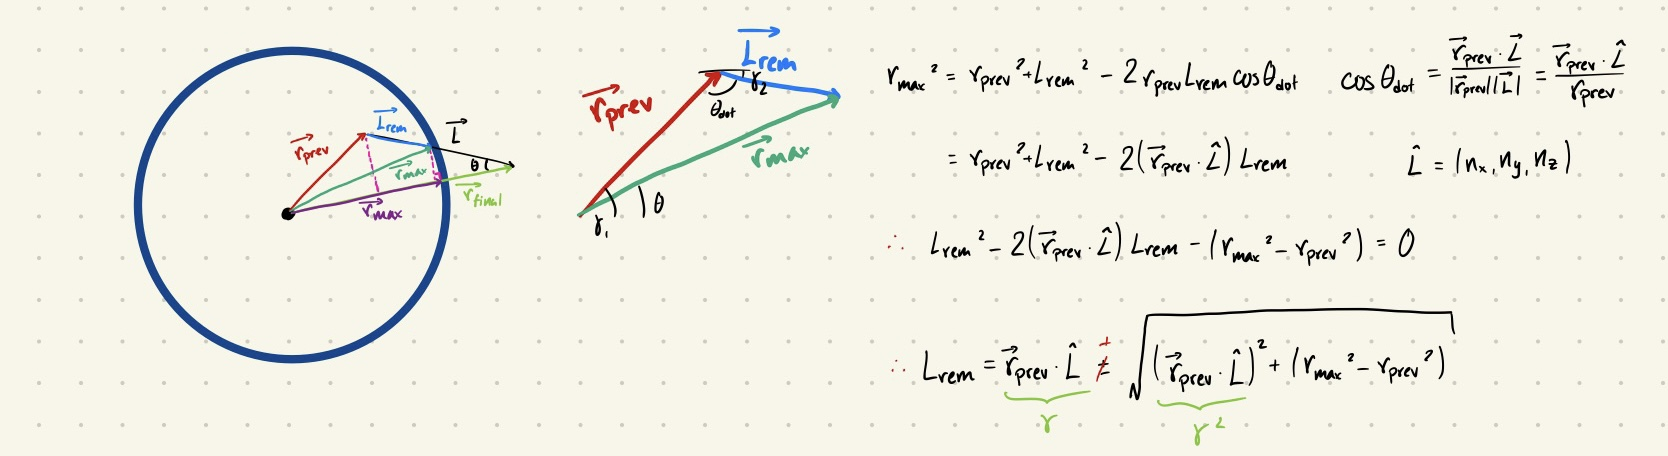

Subtracting the last $L$ and adding $L_{rem}$ (dist_correction in the programme) instead makes travel_dist give the correct travelled distance within the medium. Diving this length by the speed of light $c$ gives the ToF in seconds for the $j^{th}$ packet.

The array binned_ToFs is used to collect these ToFs. In this case, it has been set to have 100 bins of equal width between $0$ $\mathrm{ s}$ and max_ToF $ = 3*10^{-7}$ $\mathrm{s}$. max_ToF is selected to give an adequate range for data colection and presentation purposes.

Using the FLOOR function, $n$ gives the bin index a particular ToF belongs to and the value in that bin is increased by $1$ for the $j^{th}$ packet. The IF statement is necessary as it is possible to sporadically have ToFs larger than max_ToF whose index lies outwith the array range so they have to be ignored to avoid errors. If max_ToF is large enough the number of packets being unaccounted for is small.

After all the ToFs for a given $\tau_r$ have been collected they are written on a txt. document.

SYSTEM_CLOCK is called at the beginning and end of the programme to measure runtime which is usually around $16$ minutes and $30$ seconds.

The figures below show this data.

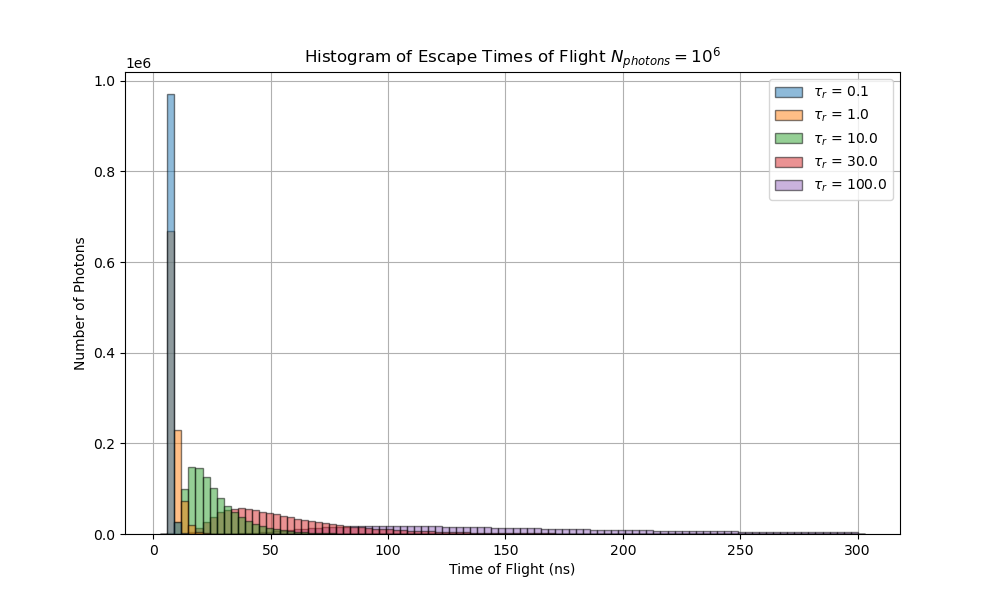

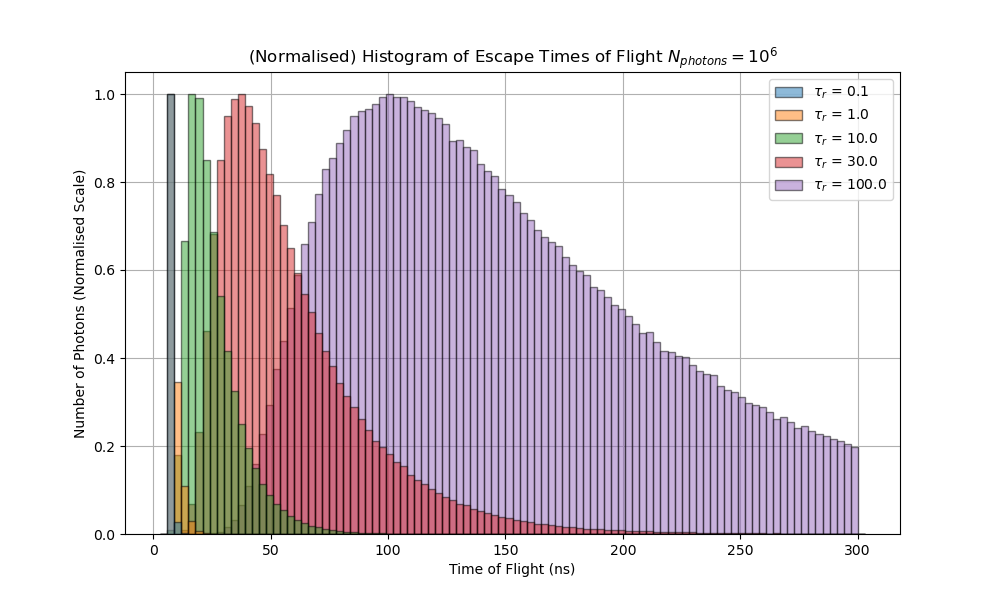

The count number under each $\tau$ histogram should roughly be equal to $10^6$, however this number becomes smaller for bigger $\tau_r$ because more packets attain ToFs larger than max_ToF. As well, the mode ToF moves to larger values with increasing $\tau_r$. This makes physical sense as a larger $\tau_r$ would require a larger propagation $\tau$ to escape the sphere in a single leg of the journey, for example, and these are less probable due to the random exponential distribution of $\tau$. Thus, it is more probable that packets will interact with particles in the medium resulting in isotropic scattering increasing the chance of prolonged travel within the medium.

It is worth noting the large collection of counts near the $0$ $\mathrm{s}$ for the optically thin case. This corresponds to the case in which the packets do not interact with anything on their way out and only travel a distance $r_{max}$ within the sphere. Were it not for the correction derived above these packets would either not be accounted for or the distances reported would vary a lot and be dominated by distance travelled outside the sphere.

It is also worth noting how the distributions tend to ressemble a Gaussian more as $\tau_r$ (and therefore the attained ToFs) increases in correspondance with the Central Limit Theorem.

## Task 2

Modify your uniform density sphere code to implement the variance reduction algorithms
of “forced first scattering” and “Roulette” and for a simulation with a central isotropic source
compute the volume density of absorbed power as a function of radius within the sphere.
Present results for simulations of uniform density spheres with scattering albedos of 0.2 and
0.6 and radial optical depths 0.2, 1, 5, and 20. Test your code modifications by comparing
with simulations without variance reduction algorithms

### Volume Density of Absorbed Power as a Function of Radius (Variance Reduced)

In [6]:
program uni_sphere_var_red
    implicit none
    double precision :: x,y,z,nx,ny,nz,tau,r,rmax,E,F,L,bw,W,W_min,roul,rbin,p
    double precision, parameter :: c = 3.d8, pi = ACOS(-1.d0) 
    integer :: npackets,i,j,k,m,n,nbins,ntaus,nalbedos
    double precision, allocatable, dimension(:) :: tau_rs,albedos,binned_power
    integer :: clock_start, clock_end, clock_rate, elapsed_time
    
    npackets = 10**8
    nbins = 100
    ntaus = 4
    nalbedos = 2
    rmax = 1.d0
    bw = rmax/REAL(nbins) ! We bin by distance from the centre in segments dr = bw which give the thickness of concentric
    ! shells with volume 4*pi*r^2*dr - this is our volume element to divide by to get density. r is halfway between the 
    ! inner and the outer edge of the shell
    p = 0.5
    W_min = 0.01
    ! p and W_min are arbitrary
    
    ! Initialize the clock
    call SYSTEM_CLOCK(count_rate=clock_rate)
    call SYSTEM_CLOCK(count=clock_start)
    
    allocate(tau_rs(ntaus))
    allocate(albedos(nalbedos))
    allocate(binned_power(nbins)) ! We want to store the amount of power deposited at a given shell (bin)
    
    tau_rs = (/2.d-1, 1.d0, 5.d0, 2.d1/) ! Length 4
    albedos = (/2.d-1, 6.d-1/) ! Length 2
    open(unit=1, file = 'HW1_2.txt')
 
    do i = 1,nalbedos ! Loop through the albedos
        do j = 1,ntaus ! Loop through the optical depths
            binned_power = 0.d0 ! Need to start with empty bins for each optical depth and albedo combination
            do k = 1,npackets ! Loop through the packets
                W = 1 - EXP(-tau_rs(j)) ! W0 = 1 so we can just set the initial weight for each packet to 
                ! 1 - EXP(-tau_rs(j)) in the case of forced first scattering
                call emit_packet(x,y,z,nx,ny,nz) ! Create a packet at the origin with random nx, ny, nz direction
                call random_number(E)
                tau = -log(1-E*(1-EXP(-tau_rs(j)))) ! The optical depth travelled in this leg of the journey which will be
                ! less than tau_r
                L = tau * rmax / tau_rs(j) ! Distance travelled, definitely < rmax
                ! update packet position, x,y,z
                x = x + L * nx
                y = y + L * ny
                z = z + L * nz
                r = SQRT(x*x + y*y + z*z) ! By the condition above, r < rmax
                m = FLOOR(r/bw)+1 ! Need to determine which "shell" this scattering event belongs to
                binned_power(m) = binned_power(m) + (1-albedos(i))*W ! Add the power absorbed to the corresponding shell 
                ! (bin)
                W = albedos(i)*W
                call ran_dir(nx,ny,nz)
                do while (r <= rmax) ! Packet is in sphere
                    call random_number(F)
                    tau = -log(F) ! The optical depth travelled in this leg of the journey. This time it is not constrained
                    ! by tau_r
                    L = tau * rmax / tau_rs(j) ! Distance travelled
                    ! update packet position, x,y,z
                    x = x + L * nx
                    y = y + L * ny
                    z = z + L * nz
                    r = SQRT(x*x + y*y + z*z)
                    if (r >= rmax) EXIT ! Packet escapes the spherical medium
                    m = FLOOR(r/bw)+1 ! Need to determine which "shell" this scattering event belongs to
                    binned_power(m) = binned_power(m) + (1-albedos(i))*W ! Add the power absorbed to the corresponding 
                    !shell (bin)
                    W = albedos(i)*W
                    if (W < W_min) then
                        call random_number(roul)
                        if (roul >= p) then
                            EXIT ! Packet terminated
                        else 
                            W = W/p ! Packet survives roulette and is re-weighted
                        end if
                    end if
                    call ran_dir(nx,ny,nz) ! If the package is not terminated then it is scattered isotropically
                end do
            end do
            print*, 'Done!'
            do n = 1, nbins
                rbin = (n-1)*bw + bw/2 ! The radius of the nth bin shell
                write(1,*) bw*n, binned_power(n)/(4*pi*rbin*rbin*bw)
            end do
        end do
    end do
    
    ! Get the ending time
    call SYSTEM_CLOCK(count=clock_end)

    ! Calculate the elapsed time in seconds
    elapsed_time = (clock_end - clock_start) / clock_rate

    print *, 'Elapsed time (seconds):', elapsed_time
    
    close(unit=1)
end program uni_sphere_var_red

subroutine emit_packet(x,y,z,nx,ny,nz)
    implicit none
    double precision, parameter :: pi = 3.14159
    double precision :: E1,E2,theta,phi
    double precision, intent(out) :: x,y,z,nx,ny,nz
    x=0
    y=0
    z=0
    call ran_dir(nx,ny,nz)
end subroutine emit_packet

subroutine ran_dir(nxs,nys,nzs)
    implicit none
    double precision, parameter :: pi = 3.14159
    double precision :: E1,E2,theta,phi
    double precision, intent(out) :: nxs,nys,nzs
    call random_number(E1)
    call random_number(E2)
    theta = ACOS(2*E1 - 1)
    phi = 2*pi*E2
    nxs = SIN(theta)*COS(phi)
    nys = SIN(theta)*SIN(phi)
    nzs = COS(theta)
end subroutine ran_dir

 Done!
 Done!
 Done!
 Done!
 Done!
 Done!
 Done!
 Done!
 Elapsed time (seconds):         822


This code is a modified version of the one in Task 1. In this case, length travelled is not being measured. Instead, the variance reduction algorithms of forced first scattering, weighted packets and roulette are employed to measure the volume density of absorbed power as a function of radius within the sphere. This time, we cycle through albedos $a=(0.2, 0.6)$, $\tau_r = (0.2,1.0,5.0,20.0)$ and up to $10^8$ packets. For each $a$ and $\tau_r$ combination the binning array binned_power is emptied to start anew.

By means of forced first scattering, each packet is not assumed to have equal weight $W = L/N (=1)$. Instead, since we neglect the packets that would escape the simulation right after being emitted we need to rescale the "useful" packets by $(1-e^{-\tau_r})$. Forced first scattering works by limiting the initial range of possible $\tau$ by using $\tau = -log(1-E*(1-e^{-\tau_r}))$ such that the first leg of the journey $L<r_{max}$ so the packet is bound to interact within the medium at least once. After propagation, the new radial position is calculated and a similar indexing method is used with the bin width and the radial position to bin the absorbed power $(1-a)*W$ at the corresponding bin in the array binned_power. The bins are equally spaced length segments originating at the origin and going all the way to $r_{max}$. Conserving energy, the new weight of the packet is $a*W$. After this, the packet is isotropically scattered by ran_dir and enters the WHILE loop which as before continues until the packet exits the sphere.

After each scattering event, the new weight is $a*W$ and this continues (unless the packet exits) until $W$ is below $W_{min}$ which is arbitrarily chosen. When this happens, we enter the roulette where if a randomly produced number is below our survival probability $p$ (also arbitrarily chosen) then the weight is rescaled to $W/p$ to conserve energy and the WHILE loop continues. Otherwise, the packet is terminated and we follow the next one.

After all the packets have been terminated, for a given $\tau_r$ and $a$ combination the power collected at each bin is divided by the volume element $dV = 4 \pi r^2 dr$ corresponding to each bin (shell of radius $r$) and written to a txt. document. $r$ of the $m^{th}$ bin is given by multiplying the bin width (radius element) by the index - 1 and adding half of the bin width so that $r$ goes from the origin to halfway between the edges of the shell.

SYSTEM_CLOCK is called at the beginning and end of the programme to measure runtime which is usually around $13$ minutes and $30$ seconds for $10^8$ packets.

### Volume Density of Absorbed Power as a Function of Radius (Not Variance Reduced)

In [5]:
program uni_sphere_not_var_red
    implicit none
    double precision :: x,y,z,nx,ny,nz,tau,r,rmax,E,F,L,bw,W,rbin
    double precision, parameter :: c = 3.d8, pi = ACOS(-1.d0) 
    integer :: npackets,i,j,k,m,n,nbins,ntaus,nalbedos
    double precision, allocatable, dimension(:) :: tau_rs,albedos,binned_power
    integer :: clock_start, clock_end, clock_rate, elapsed_time

    
    npackets = 10**8
    nbins = 100
    ntaus = 4
    nalbedos = 2
    rmax = 1.d0
    bw = rmax/REAL(nbins) ! We bin by distance from the centre in segments dr = bw which give the thickness of concentric
    ! shells with volume 4*pi*r^2*dr - this is our volume element to divide by to get density. r is halfway between the 
    ! inner and the outer edge of the shell
    W = 1.d0
    
    ! Initialize the clock
    call SYSTEM_CLOCK(count_rate=clock_rate)
    call SYSTEM_CLOCK(count=clock_start)
    
    allocate(tau_rs(ntaus))
    allocate(albedos(nalbedos))
    allocate(binned_power(nbins)) ! We want to store the amount of power deposited at a given shell (bin)
    
    tau_rs = (/2.d-1, 1.d0, 5.d0, 2.d1/) ! Length 4
    albedos = (/2.d-1, 6.d-1/) ! Length 2
    open(unit=1, file = 'HW1_3.txt')
 
    do i = 1,nalbedos ! Loop through the albedos
        do j = 1,ntaus ! Loop through the optical depths
            binned_power = 0.d0 ! Need to start with empty bins for each optical depth and albedo combination
            do k = 1,npackets ! Loop through the packets
                call emit_packet(x,y,z,nx,ny,nz) ! Create a packet at the origin with random nx, ny, nz direction
                r = SQRT(x*x + y*y + z*z) ! Need this to start the WHILE loop
                do while (r <= rmax) ! Packet is in sphere
                    call random_number(E)
                    tau = -log(E) ! The optical depth travelled in this leg of the journey. This time it is not constrained
                    ! by tau_r
                    L = tau * rmax / tau_rs(j) ! Distance travelled
                    ! update packet position, x,y,z
                    x = x + L * nx
                    y = y + L * ny
                    z = z + L * nz
                    r = SQRT(x*x + y*y + z*z)
                    if (r >= rmax) EXIT ! Packet escapes the spherical medium
                    call random_number(F)
                    if (F > albedos(i)) then
                        m = FLOOR(r/bw)+1 ! Need to determine which "shell" this scattering event belongs to
                        binned_power(m) = binned_power(m) + W ! Add the power absorbed to the corresponding 
                        !shell (bin)
                        EXIT
                    end if
                    call ran_dir(nx,ny,nz) ! If the package does not exit the medium then it is scattered isotropically
                end do
            end do
            print*, 'Done!'
            do n = 1, nbins
                rbin = (n-1)*bw + bw/2 ! The radius of the nth bin shell
                write(1,*) bw*n, binned_power(n)/(4*pi*rbin*rbin*bw)
            end do
        end do
    end do
    
    ! Get the ending time
    call SYSTEM_CLOCK(count=clock_end)

    ! Calculate the elapsed time in seconds
    elapsed_time = (clock_end - clock_start) / clock_rate

    print *, 'Elapsed time (seconds):', elapsed_time
    
    close(unit=1)
end program uni_sphere_not_var_red

subroutine emit_packet(x,y,z,nx,ny,nz)
    implicit none
    double precision, parameter :: pi = 3.14159
    double precision :: E1,E2,theta,phi
    double precision, intent(out) :: x,y,z,nx,ny,nz
    x=0
    y=0
    z=0
    call ran_dir(nx,ny,nz)
end subroutine emit_packet

subroutine ran_dir(nxs,nys,nzs)
    implicit none
    double precision, parameter :: pi = 3.14159
    double precision :: E1,E2,theta,phi
    double precision, intent(out) :: nxs,nys,nzs
    call random_number(E1)
    call random_number(E2)
    theta = ACOS(2*E1 - 1)
    phi = 2*pi*E2
    nxs = SIN(theta)*COS(phi)
    nys = SIN(theta)*SIN(phi)
    nzs = COS(theta)
end subroutine ran_dir

 Done!
 Done!
 Done!
 Done!
 Done!
 Done!
 Done!
 Done!
 Elapsed time (seconds):         254


This code is a modified version of the one above. Here, we do not implement the variance reduction algorithms. Instead, we simply run through all packets and at each interaction event produce a random number. If this is bigger than the $a$ of the simulation then the total weight (in this case $W=1$ as we are not using forced first scattering) is assumed to be absorbed at that radius so simply $W$ is added to the bin corresponding to that radius and the package is terminated. Otherwise, the package is scattered as usual and the WHILE loop continues.

SYSTEM_CLOCK is called at the beginning and end of the programme to measure runtime which is usually around $5$ minutes for $10^8$ packets.

The figures below show the data for both methods for different numbers of packets.

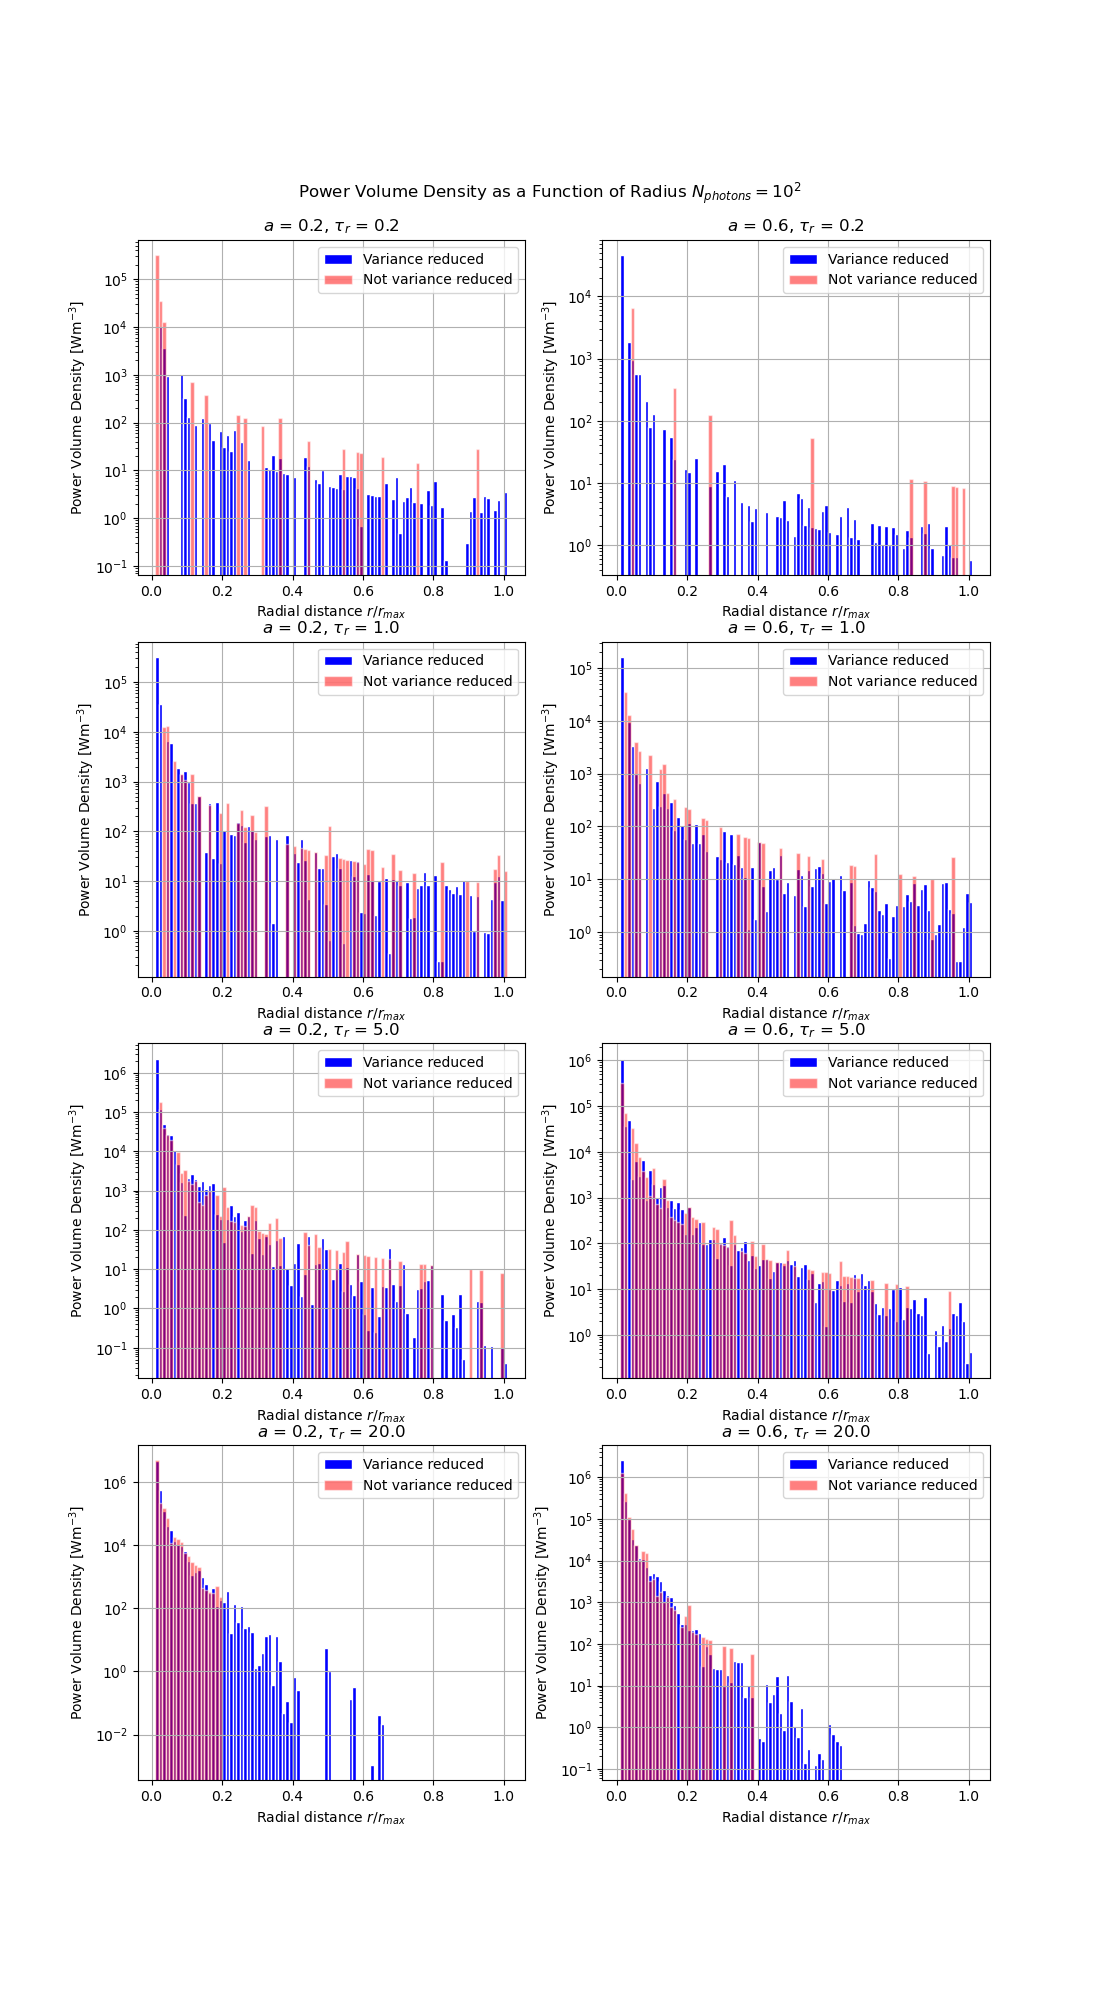

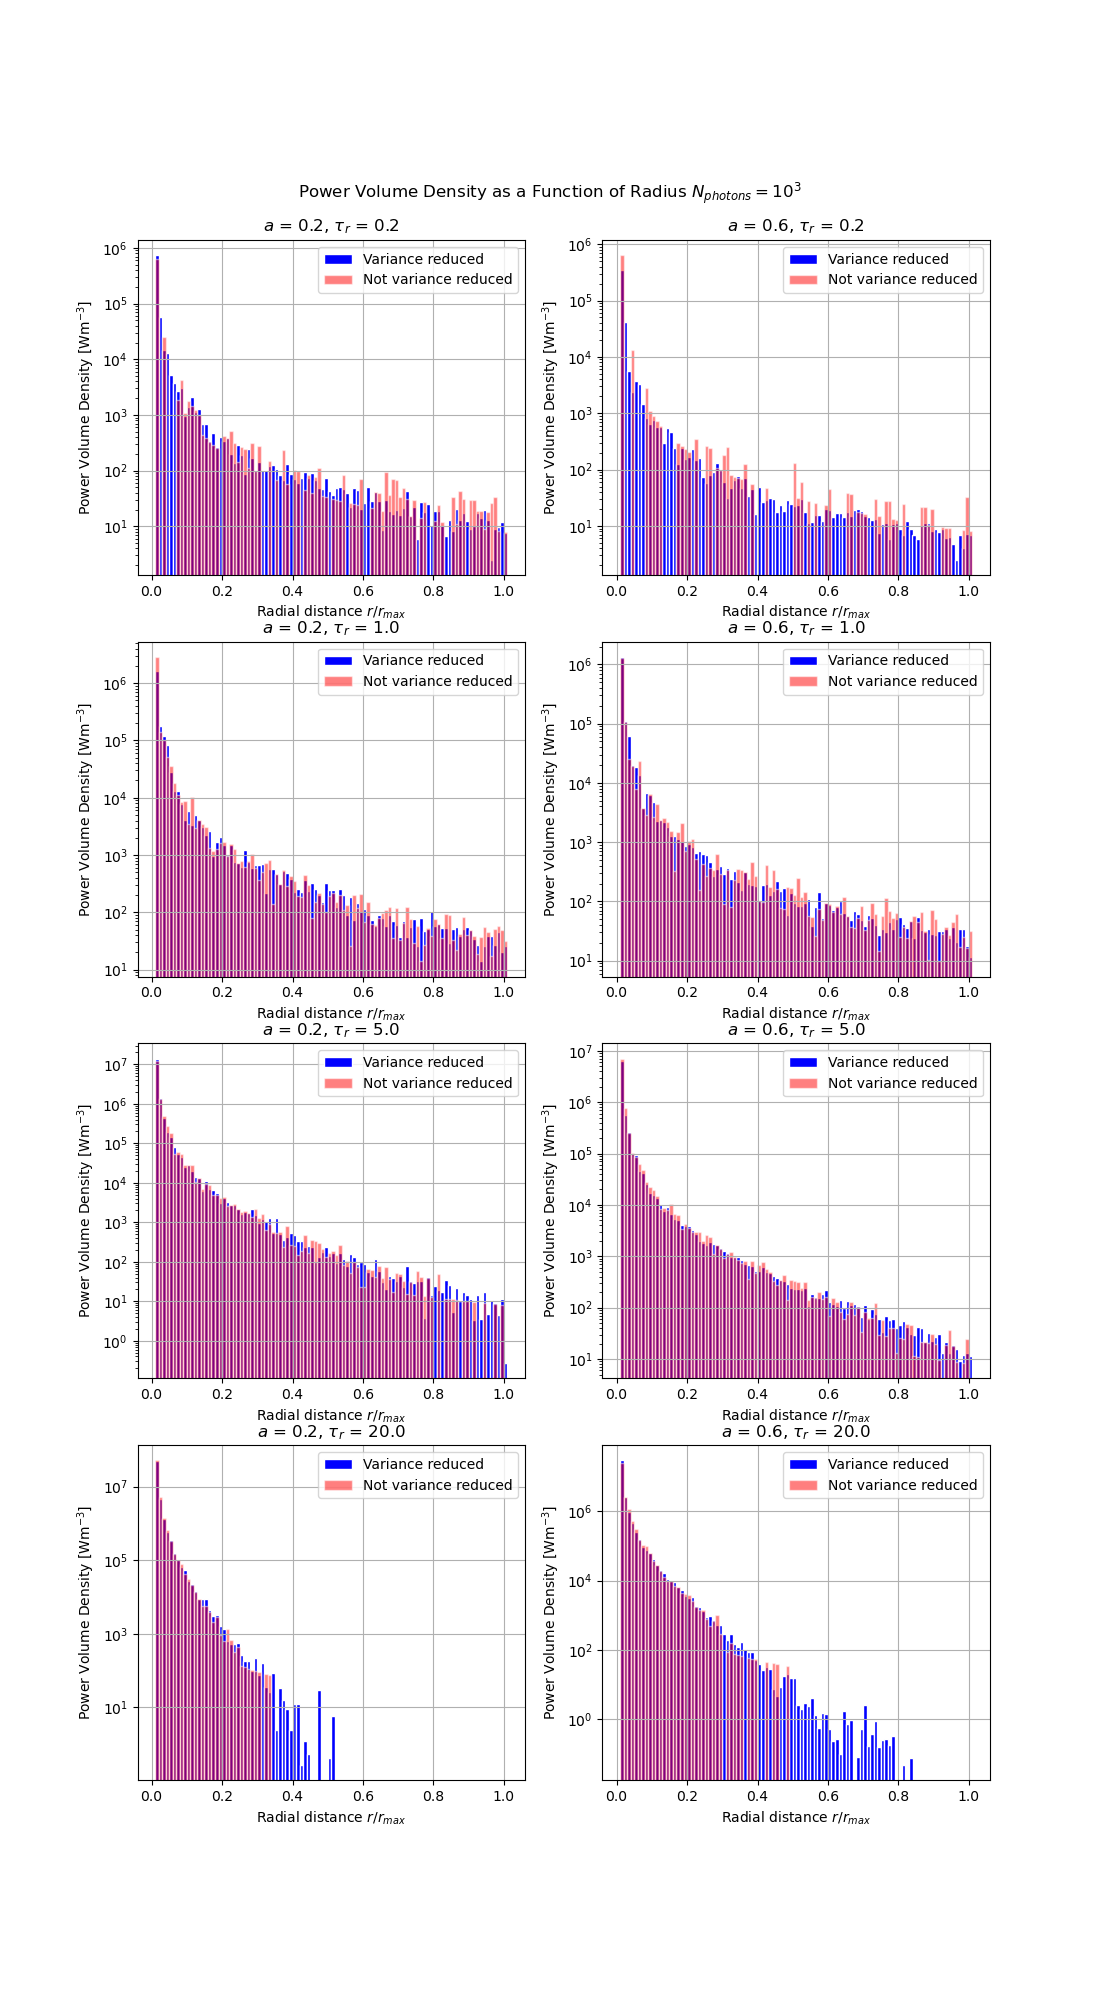

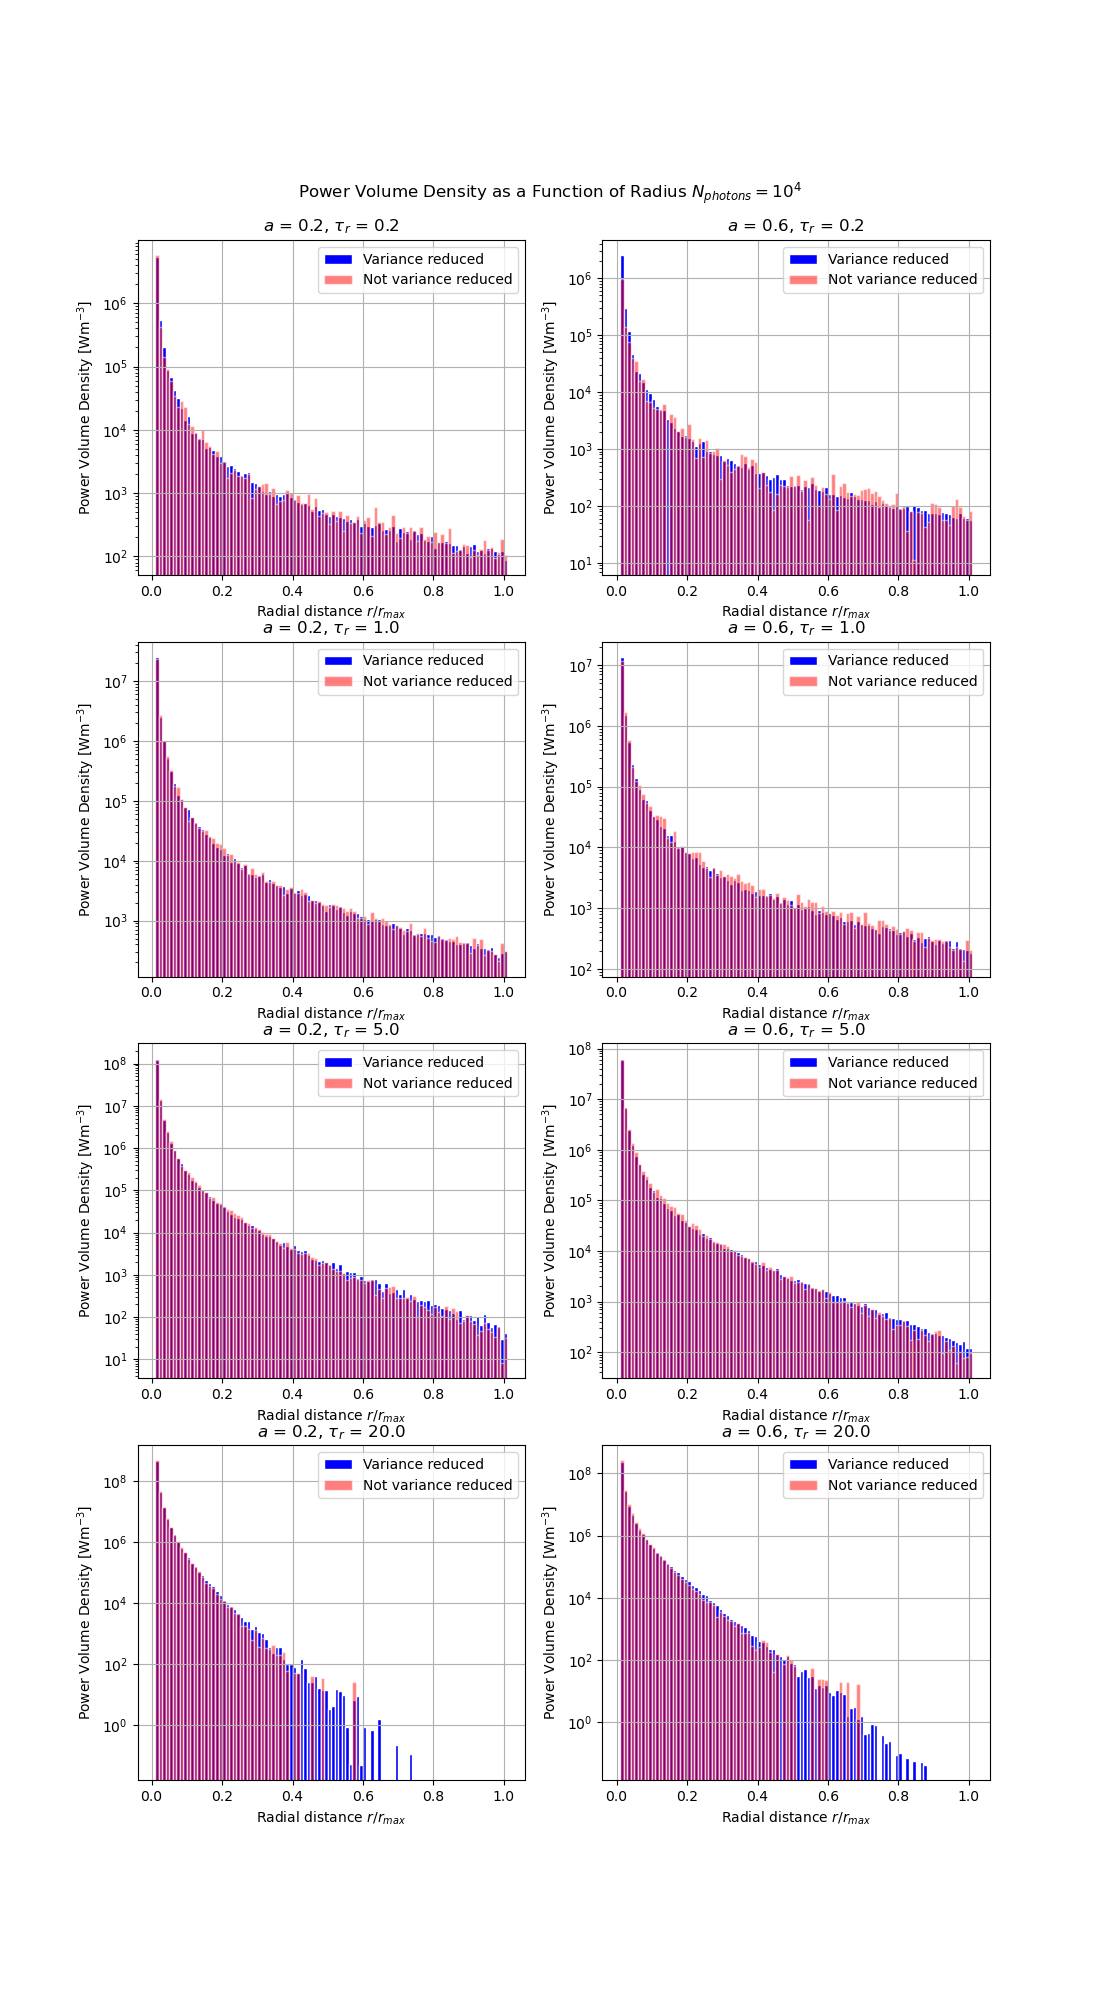

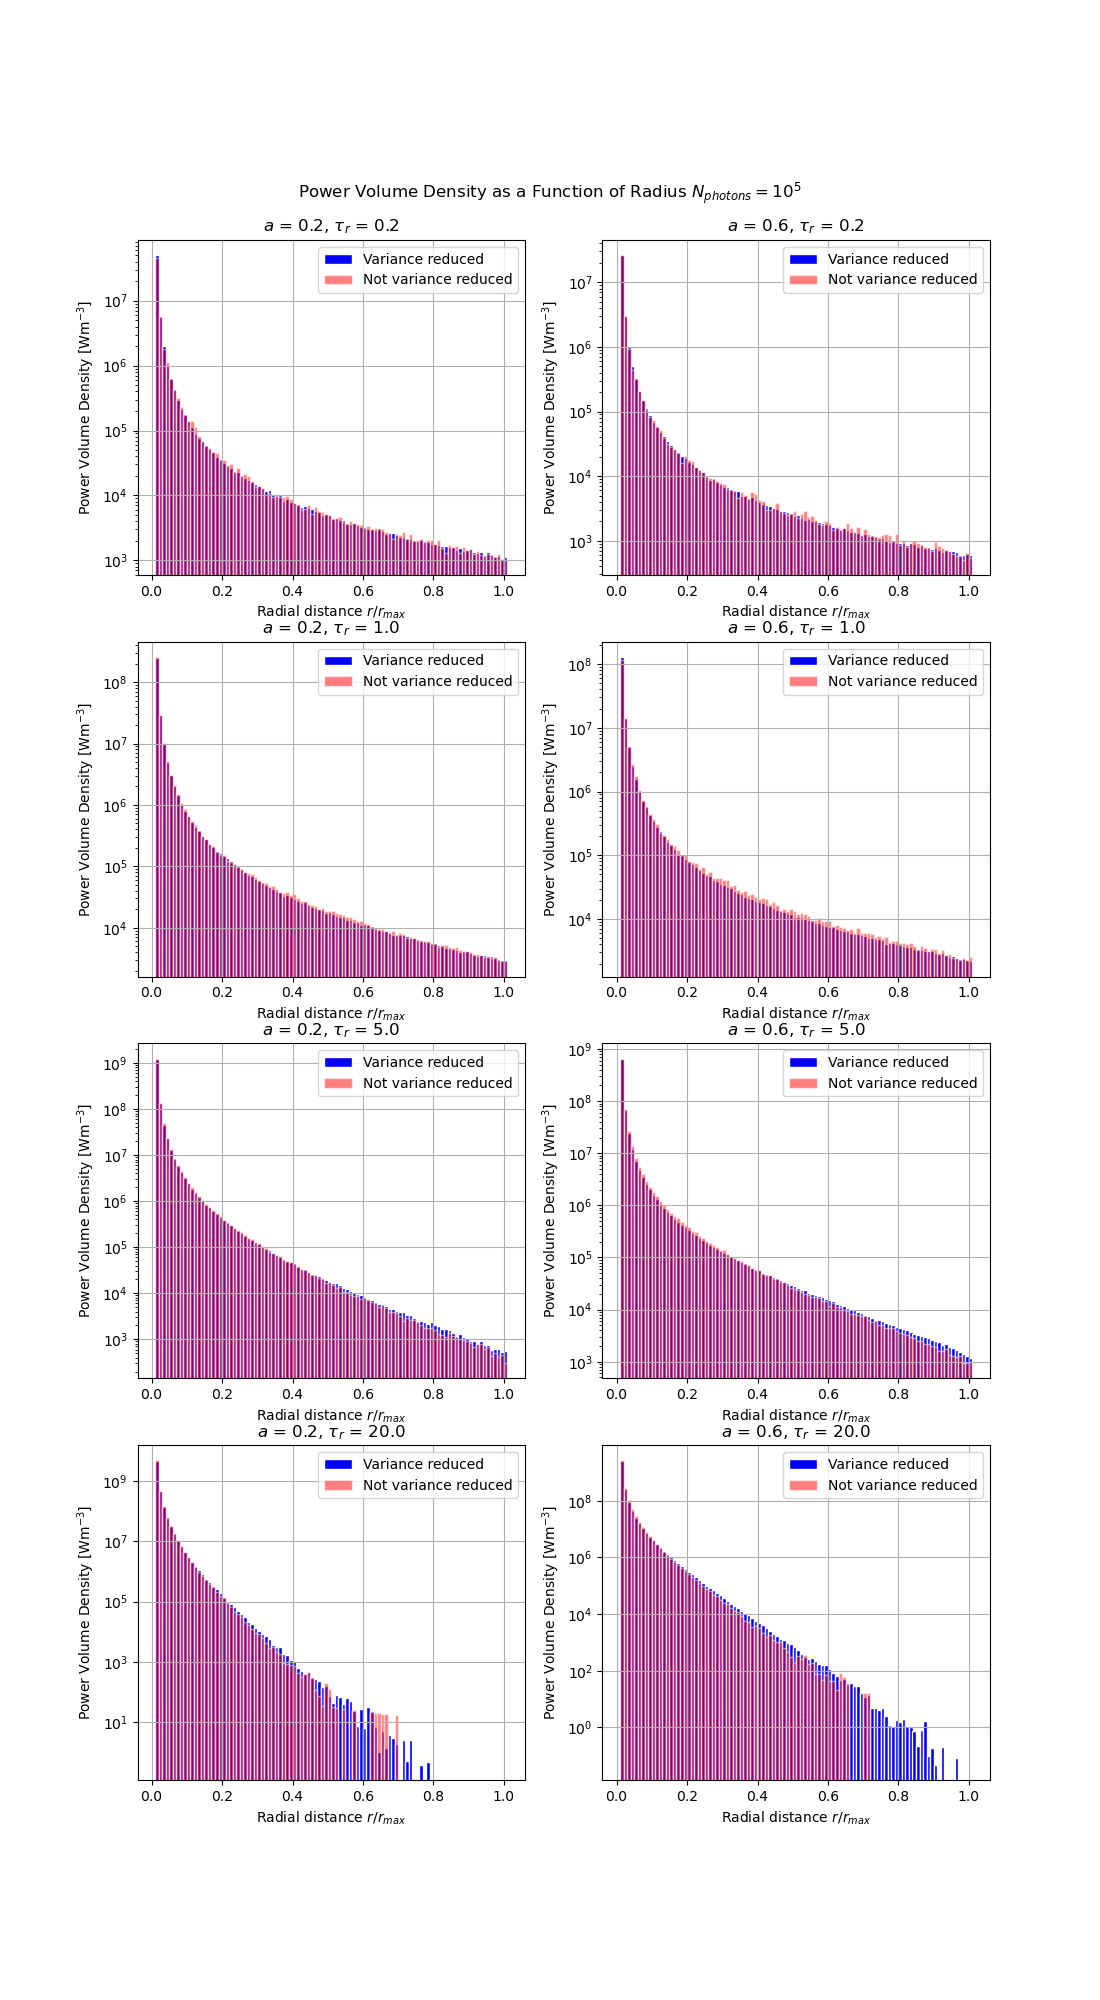

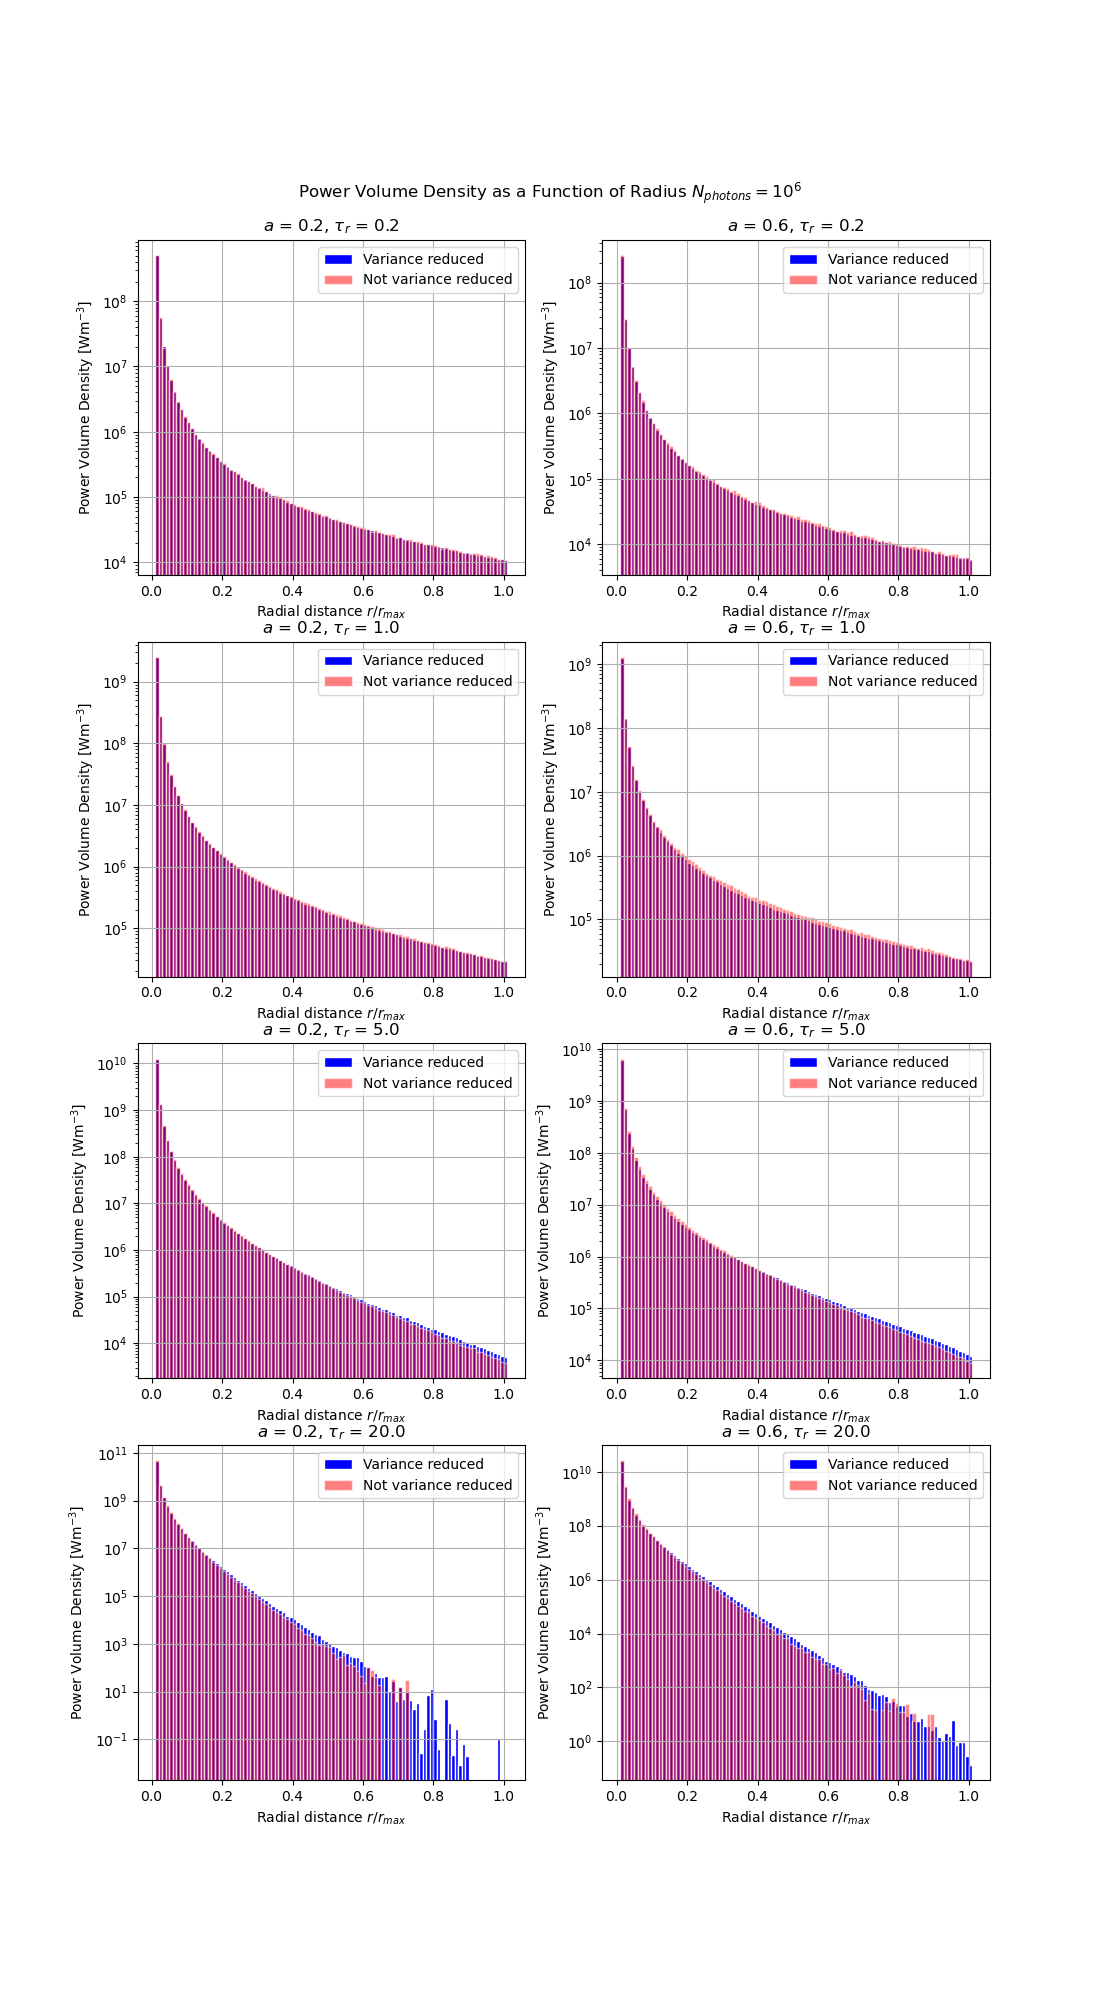

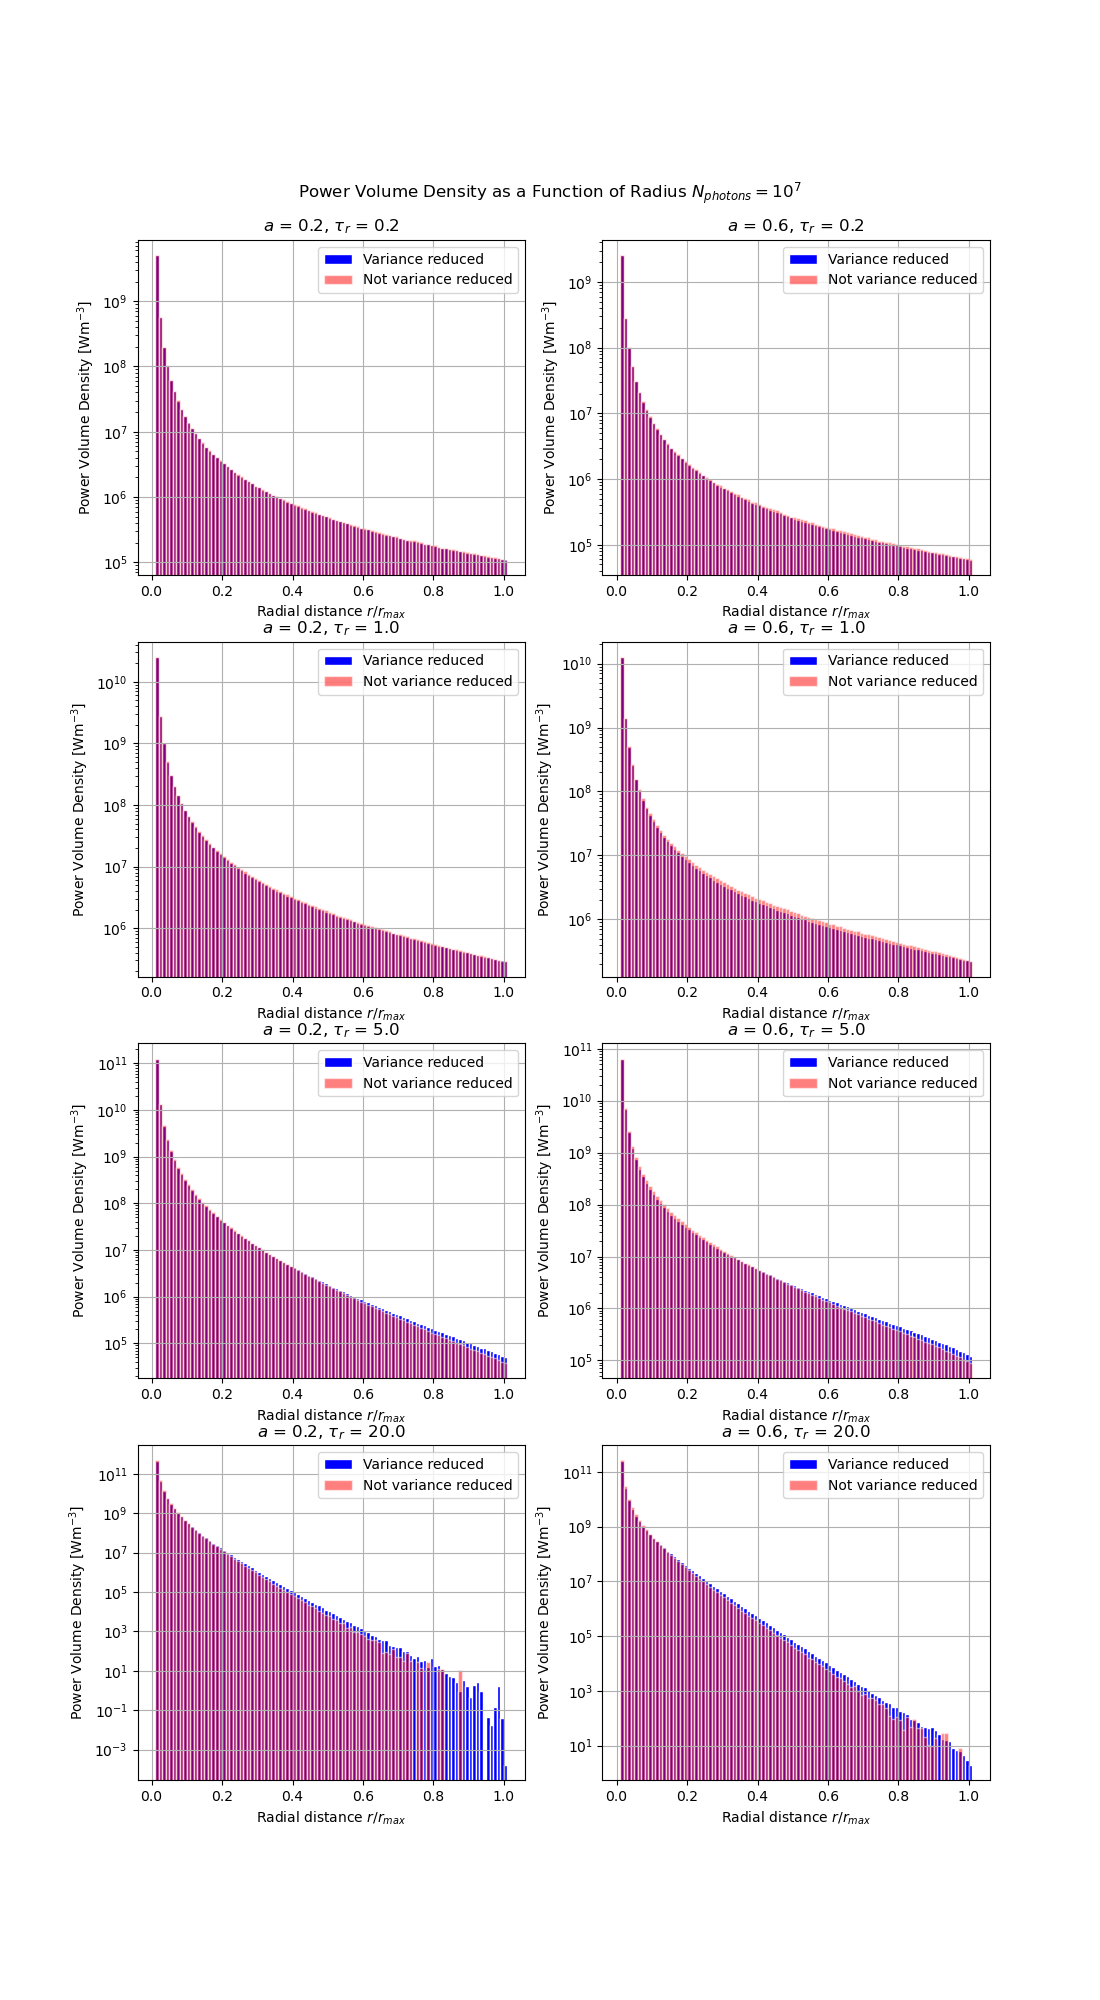

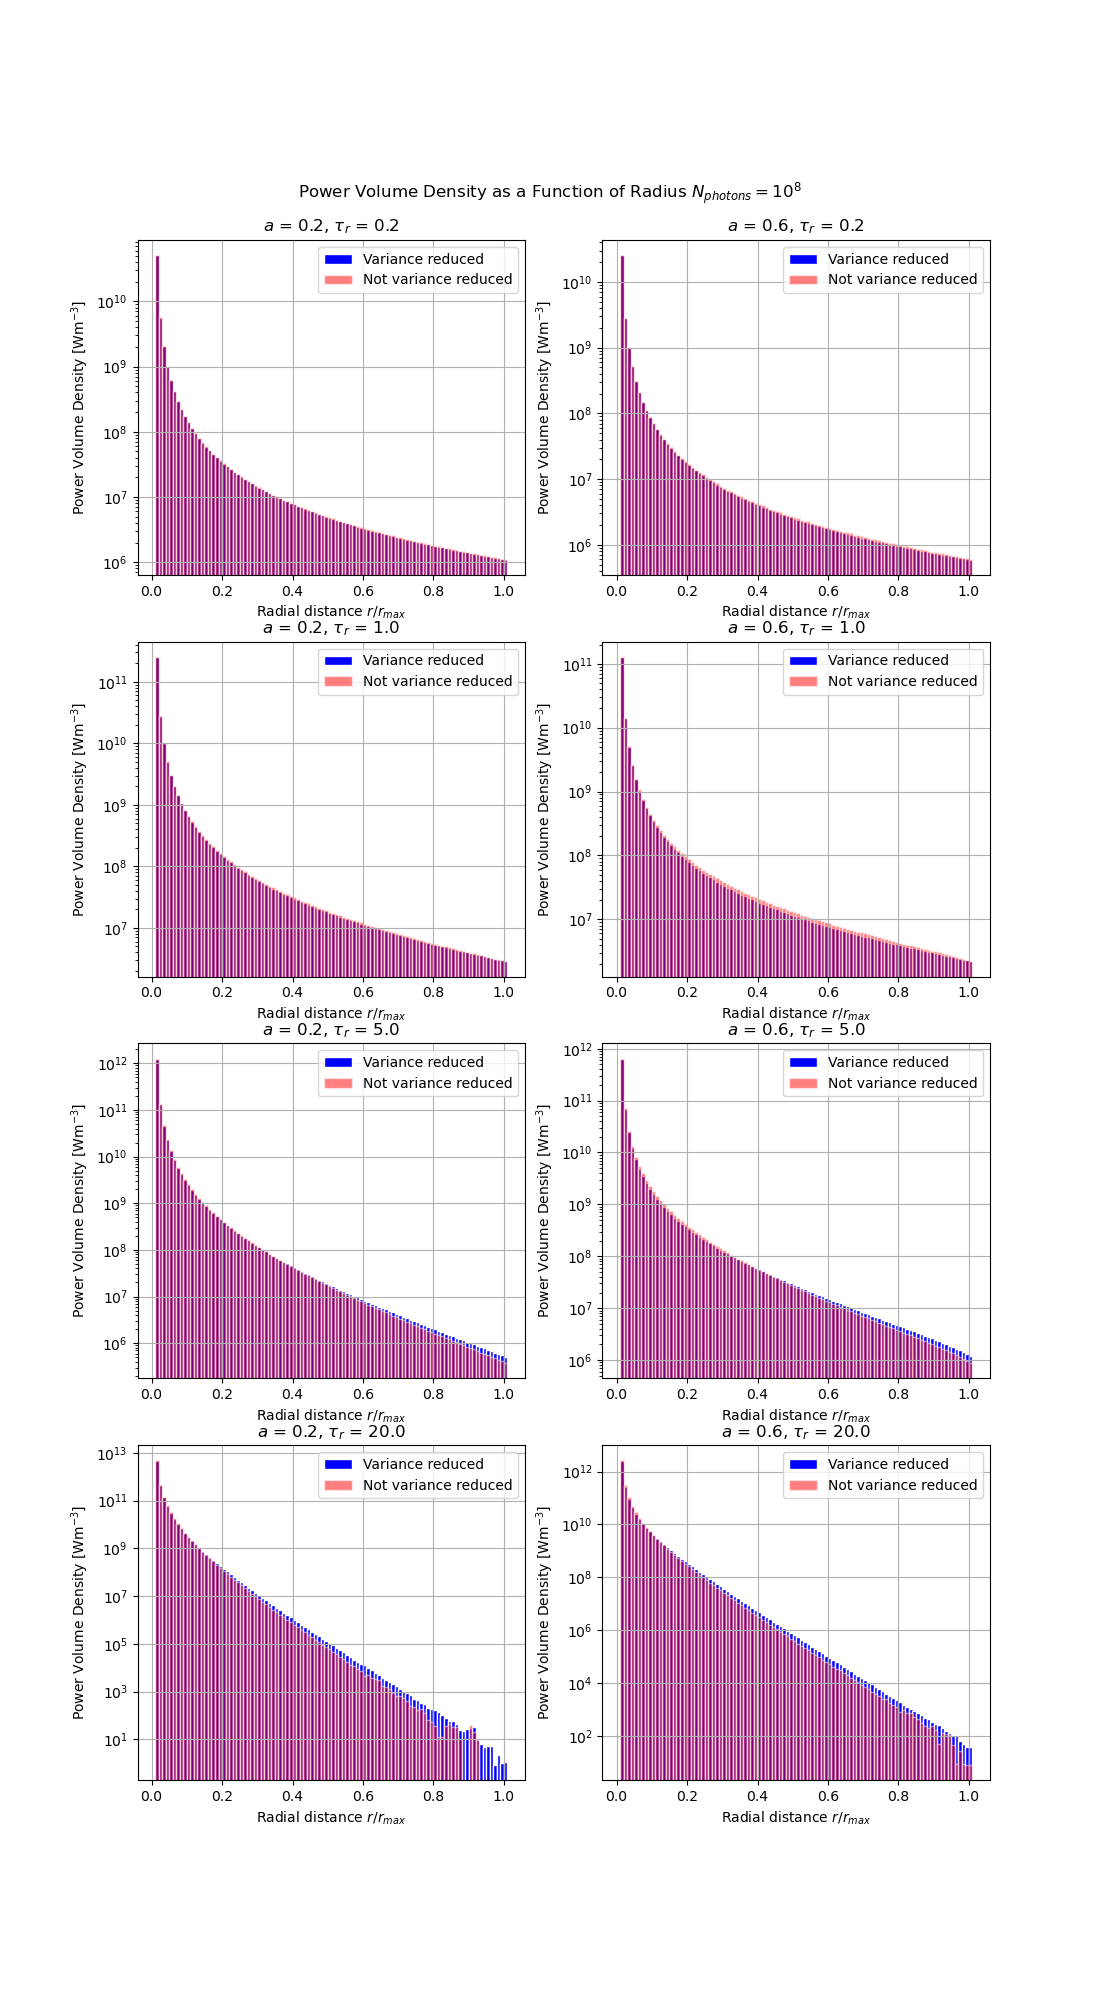

As can be seen in the figures above, for lower packet number, the variance reduced plot is typically smoother, has more data points at more radii and has a much wider range than for the non-variance reduced one. The latter is true for large $tau_r$ too for all packet numbers. Nevertheless, the differences between the plots become smaller with increasing number of packet in accordance with the Law of Large Numbers.

Also, for the same $\tau_r$ but different $a$ the histogram with larger $a$ decline less steeply. This is to be expected as larger $a$ means that the absorption probability (or scale factor) is much smaller so packets can travel for longer increasing their absorption radius. As well, it is notable that the plot becomes more linear (with the log-scaled y axis) for greater $tau_r$ values.

However, it must be noted that non-variance reduced data takes about a third of the time to calculate compared to the variance reduced data for the same number of packets.